In [4]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import cv2
import matplotlib.pyplot as plt
import ale_py

In [5]:
# DeepQNetwork class
class DeepQNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DeepQNetwork, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, output_dim)
        )


    def forward(self, x):
        return self.net(x)

In [6]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.pos = 0

    def push(self, state, action, reward, next_state, next_action, done):
        data = (state, action, reward, next_state, next_action, done)
        if len(self.buffer) < self.capacity:
            self.buffer.append(data)
        else:
            self.buffer[self.pos] = data
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, next_actions, dones = map(np.array, zip(*batch))

        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(next_actions, dtype=torch.int64),
            torch.tensor(dones, dtype=torch.float32),
        )

    def __len__(self):
        return len(self.buffer)

In [12]:
class SarsaGradientAgent():
    def __init__(self, env, input_dim=8, buffer_capacity=100000, learning_rate=1e-4):
        self.env = gym.make(env)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.path = f'{env}/'
        
        self.batch_size = 128
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_end = 0.001
        self.epsilon_decay = 0.992
        self.learning_rate = learning_rate

        self.weights = np.zeros((self.env.action_space.n, input_dim))
        
        self.q_network = DeepQNetwork(input_dim, self.env.action_space.n).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        self.buffer = ReplayBuffer(buffer_capacity)

        self.episode = 0
        self.reward_episode = 0
        self.total_reward = []
        self.total_reward_moving_avg = []
        self.x_position = []
        self.y_position = []
        
    def epsilon_greedy(self, model, state, epsilon, device):
        if random.random() < epsilon:
            return self.env.action_space.sample()
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            q_vals = model(state_tensor)
        return torch.argmax(q_vals).item()
    
    def q_value(self, state):
        return np.dot(self.weights, state)
    
    def simple_epsilon_greedy(self, state, epsilon):
        if random.random() < epsilon:
            return self.env.action_space.sample()
        else:
            q_values = self.q_value(state)
            return np.argmax(q_values)
        

    def train_simple_sarsa(self, num_episodes=1000):
        for episode in range(num_episodes):
            self.reward_episode = 0
            state, _ = self.env.reset()
            action = self.simple_epsilon_greedy(state, self.epsilon)
            done = False
            
            while not done:
                
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                next_action = self.simple_epsilon_greedy(next_state, self.epsilon)
                q_sa = np.dot(self.weights[action], state)
                q_s_next_a = np.dot(self.weights[next_action], next_state)
                td_error = reward + self.gamma * q_s_next_a - q_sa

                self.weights[action] += self.learning_rate * td_error * state
                
                state = next_state
                action = next_action
                self.reward_episode += reward
            
            self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
            self.total_reward.append(self.reward_episode)
            print(f"Episode {episode} — Total Reward: {self.reward_episode:.2f} — Epsilon: {self.epsilon:.3f}")
    
    def train_no_experience(self, num_episodes=1000):
        for episode in range(1, num_episodes + 1):
            self.reward_episode = 0
            done = False
            state, _ = self.env.reset()
            action = self.epsilon_greedy(self.q_network, state, self.epsilon, self.device)

            while not done:
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                self.reward_episode += reward

                next_action = self.epsilon_greedy(self.q_network, next_state, self.epsilon, self.device)

                state_tensor      = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
                action_tensor     = torch.tensor([action], dtype=torch.int64).to(self.device)
                reward_tensor     = torch.tensor([reward], dtype=torch.float32).to(self.device)
                next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(self.device)
                next_action_tensor= torch.tensor([next_action], dtype=torch.int64).to(self.device)
                done_tensor       = torch.tensor([done], dtype=torch.float32).to(self.device)

                q_values = self.q_network(state_tensor)
                q_sa = q_values.gather(1, action_tensor.unsqueeze(1)).squeeze(1)

                with torch.no_grad():
                    q_next = self.q_network(next_state_tensor)
                    q_snext_anext = q_next.gather(1, next_action_tensor.unsqueeze(1)).squeeze(1)

                td_target = reward_tensor + self.gamma * q_snext_anext * (1 - done_tensor)

                loss = F.mse_loss(q_sa, td_target)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                state, action = next_state, next_action

            self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

            self.total_reward.append(self.reward_episode)
            print(f"Episode {episode} — Total Reward: {self.reward_episode:.2f} — Epsilon: {self.epsilon:.3f}")


    
    def train(self, num_episodes=1000):
        for episode in range(1, num_episodes+1):
            self.reward_episode = 0
            done = False
            state, _ = self.env.reset()
            action = self.epsilon_greedy(self.q_network, state, self.epsilon, self.device)
            if episode % 50 == 0 or episode == 1:
                self.save_checkpoints_bath(batch=str(episode))
                self.save_positions(batch=str(episode))
                self.reset_position()
            
            while done == False:

                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                self.reward_episode += reward

                next_action = self.epsilon_greedy(self.q_network, next_state, self.epsilon, self.device)

                self.buffer.push(state, action, reward, next_state, next_action, done)

                state, action = next_state, next_action

                self.x_position.append(state[0])
                self.y_position.append(state[1])

                if len(self.buffer) >= self.batch_size:
                    states, actions, rewards, next_states, next_actions, dones = self.buffer.sample(self.batch_size)

                    states      = states.to(self.device)
                    actions     = actions.to(self.device)
                    rewards     = rewards.to(self.device)
                    next_states = next_states.to(self.device)
                    next_actions= next_actions.to(self.device)
                    dones       = dones.to(self.device)

                    q_values = self.q_network(states)
                    q_sa     = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

                    q_next = self.q_network(next_states)
                    q_snext_anext = q_next.gather(1, next_actions.unsqueeze(1)).squeeze(1)

                    td_target = rewards + self.gamma * q_snext_anext * (1 - dones)

                    loss = F.mse_loss(q_sa, td_target.detach())
                    
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                
            self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)         
            self.total_reward.append(self.reward_episode)
            print(f"Episode {episode} — Total Reward: {self.reward_episode:.2f} — Epsilon: {self.epsilon:.3f}")


    def save_checkpoints(self,):
        torch.save(self.q_network.state_dict(), self.path + 'model_weights.pth')
        torch.save({'epsilon': self.epsilon_end, 'episode': self.episode, 'rewards':self.reward_episode, 'moving_average':self.total_reward_moving_avg}, self.path + "params.pth")

    def save_checkpoints_bath(self, batch):
        torch.save(self.q_network.state_dict(), self.path + f'{batch}_model_weights.pth')
        torch.save({'epsilon': self.epsilon_end, 'episode': self.episode, 'rewards':self.reward_episode, 'moving_average':self.total_reward_moving_avg}, self.path + f'{batch}_params.pth')


    def create_average_moving_window(self, window_size=100):
        for i in range(1, window_size):
            self.total_reward_moving_avg.append(np.mean(self.total_reward[:i]))
        for i in range(window_size, len(self.total_reward)+1):
            self.total_reward_moving_avg.append(np.mean(self.total_reward[i-window_size:i]))
    
    def load_checkpoints(self, weights_file, params_file):
        self.q_network.load_state_dict(torch.load(self.path + weights_file, weights_only=False))
        checkpoint = torch.load(self.path + params_file, weights_only=False)
        return checkpoint
    
    def plot_rewards(self):
        episodes = np.arange(len(self.total_reward))
        moving_avg = []
        window_size = 100
        for i in range(1, window_size):
            moving_avg.append(np.mean(self.total_reward[:i]))
        for i in range(window_size, len(self.total_reward)+1):
            moving_avg.append(np.mean(self.total_reward[i-window_size:i]))
        plt.plot(episodes, self.total_reward, label='Total Reward per Episode')
        plt.plot(episodes, moving_avg, label='Moving Average (window size = 100)')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Total Reward per Episode')
        plt.legend()
        plt.show()
    
    
    def play(self, env='LunarLander-v3', enable_wind=False, num_episodes=10):
        self.env = gym.make(env, enable_wind=enable_wind, wind_power=15.0, gravity=-10.0, turbulence_power=1.5, render_mode='human')
        for episode in range(num_episodes):
            done = False
            state, _ = self.env.reset()
            action = self.epsilon_greedy(self.q_network, state, self.epsilon, self.device)

            while not done:
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                action = self.epsilon_greedy(self.q_network, next_state, self.epsilon, self.device)
                state = next_state

            print(f"Episode {episode + 1} finished.")
        self.env.close()
    
    def save_positions(self, batch):
        torch.save({'xposition':self.x_position}, self.path + 'SARSA/xposition/xpo_' + str(batch) + '.npy')
        torch.save({'yposition':self.y_position}, self.path + 'SARSA/yposition/ypo_' + str(batch) + '.npy')

    def reset_position(self):
        self.x_position = []
        self.y_position = []

    def plot_positions(self, batch):
        x_position = torch.load(self.path + batch + '_x_position.npy', weights_only=False)
        y_position = torch.load(self.path + batch + '_y_position.npy', weights_only=False)
        plt.hist2d(x_position, y_position, bins=100, alpha=0.5, cmap=plt.cm.jet, range=[[-1.5, 1.5], [-1.5, 1.5]])
        plt.title('2D Histogram of Positions')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.show()            

# Semi-gradient SARSA

In [13]:
agent_simple_sarsa = SarsaGradientAgent(env='LunarLander-v3', learning_rate=0.0003)
agent_simple_sarsa.train_simple_sarsa(num_episodes=2000)

Episode 0 — Total Reward: -64.66 — Epsilon: 0.992
Episode 1 — Total Reward: -107.61 — Epsilon: 0.984
Episode 2 — Total Reward: -116.25 — Epsilon: 0.976
Episode 3 — Total Reward: -90.74 — Epsilon: 0.968
Episode 4 — Total Reward: -78.09 — Epsilon: 0.961
Episode 5 — Total Reward: -326.38 — Epsilon: 0.953
Episode 6 — Total Reward: -108.88 — Epsilon: 0.945
Episode 7 — Total Reward: -28.15 — Epsilon: 0.938
Episode 8 — Total Reward: -213.52 — Epsilon: 0.930
Episode 9 — Total Reward: -36.03 — Epsilon: 0.923
Episode 10 — Total Reward: -92.97 — Epsilon: 0.915
Episode 11 — Total Reward: -32.65 — Epsilon: 0.908
Episode 12 — Total Reward: -28.69 — Epsilon: 0.901
Episode 13 — Total Reward: -31.87 — Epsilon: 0.894
Episode 14 — Total Reward: -104.88 — Epsilon: 0.886
Episode 15 — Total Reward: -473.29 — Epsilon: 0.879
Episode 16 — Total Reward: -273.14 — Epsilon: 0.872
Episode 17 — Total Reward: -164.60 — Epsilon: 0.865
Episode 18 — Total Reward: -418.64 — Epsilon: 0.858
Episode 19 — Total Reward: -325

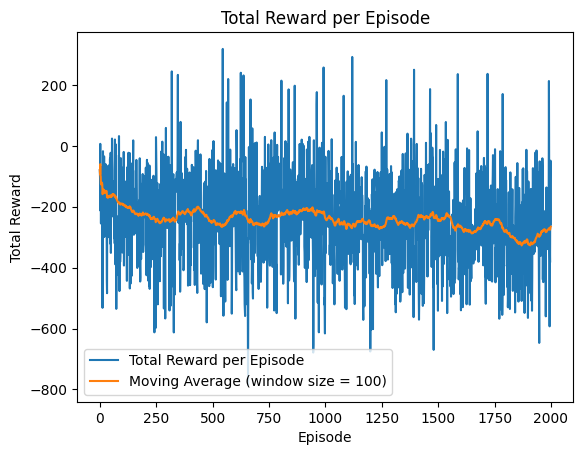

In [6]:
agent_simple_sarsa.total_reward_moving_avg = []
agent_simple_sarsa.create_average_moving_window(window_size=100)
agent_simple_sarsa.plot_rewards()

# DEEP SARSA NN (DSN)

In [7]:
agent_dsn = SarsaGradientAgent(env='LunarLander-v3', learning_rate=0.0003)
agent_dsn.train_no_experience(num_episodes=2000)

Episode 1 — Total Reward: -65.01 — Epsilon: 0.992
Episode 2 — Total Reward: -294.90 — Epsilon: 0.984
Episode 3 — Total Reward: -143.39 — Epsilon: 0.976
Episode 4 — Total Reward: -115.78 — Epsilon: 0.968
Episode 5 — Total Reward: -251.75 — Epsilon: 0.961
Episode 6 — Total Reward: -28.53 — Epsilon: 0.953
Episode 7 — Total Reward: -409.21 — Epsilon: 0.945
Episode 8 — Total Reward: -202.94 — Epsilon: 0.938
Episode 9 — Total Reward: -322.60 — Epsilon: 0.930
Episode 10 — Total Reward: -88.57 — Epsilon: 0.923
Episode 11 — Total Reward: -176.64 — Epsilon: 0.915
Episode 12 — Total Reward: -45.34 — Epsilon: 0.908
Episode 13 — Total Reward: -79.17 — Epsilon: 0.901
Episode 14 — Total Reward: -98.74 — Epsilon: 0.894
Episode 15 — Total Reward: -268.53 — Epsilon: 0.886
Episode 16 — Total Reward: -280.36 — Epsilon: 0.879
Episode 17 — Total Reward: -108.58 — Epsilon: 0.872
Episode 18 — Total Reward: -326.99 — Epsilon: 0.865
Episode 19 — Total Reward: -30.40 — Epsilon: 0.858
Episode 20 — Total Reward: -

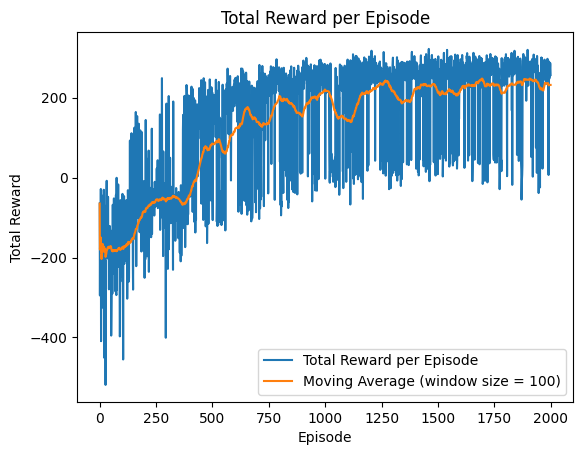

In [8]:
agent_dsn.total_reward_moving_avg = []
agent_dsn.create_average_moving_window(window_size=100)
agent_dsn.plot_rewards()

# Deep SARSA Q-Network (DSQN)

In [14]:
agent = SarsaGradientAgent(env='LunarLander-v3', learning_rate=0.0003)
agent.train(num_episodes=1500)

Episode 1 — Total Reward: -391.77 — Epsilon: 0.992
Episode 2 — Total Reward: -244.71 — Epsilon: 0.984
Episode 3 — Total Reward: -36.99 — Epsilon: 0.976
Episode 4 — Total Reward: -96.02 — Epsilon: 0.968
Episode 5 — Total Reward: -168.11 — Epsilon: 0.961
Episode 6 — Total Reward: -344.02 — Epsilon: 0.953
Episode 7 — Total Reward: -79.67 — Epsilon: 0.945
Episode 8 — Total Reward: -307.20 — Epsilon: 0.938
Episode 9 — Total Reward: -93.49 — Epsilon: 0.930
Episode 10 — Total Reward: -82.66 — Epsilon: 0.923
Episode 11 — Total Reward: -181.02 — Epsilon: 0.915
Episode 12 — Total Reward: -120.51 — Epsilon: 0.908
Episode 13 — Total Reward: -247.51 — Epsilon: 0.901
Episode 14 — Total Reward: -253.64 — Epsilon: 0.894
Episode 15 — Total Reward: -113.83 — Epsilon: 0.886
Episode 16 — Total Reward: -70.72 — Epsilon: 0.879
Episode 17 — Total Reward: -115.00 — Epsilon: 0.872
Episode 18 — Total Reward: -115.34 — Epsilon: 0.865
Episode 19 — Total Reward: -89.07 — Epsilon: 0.858
Episode 20 — Total Reward: -

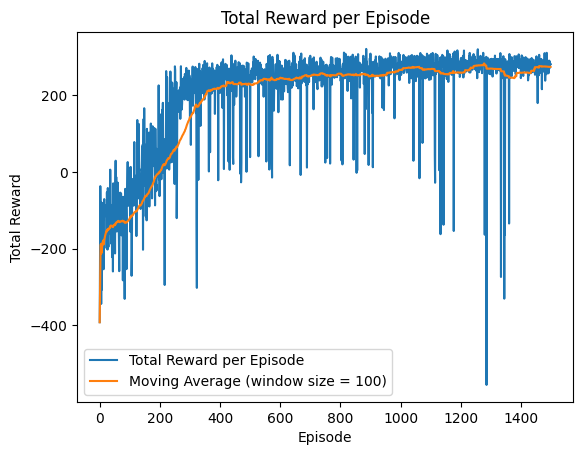

In [16]:
agent.total_reward_moving_avg = []
agent.create_average_moving_window(window_size=100)
agent.plot_rewards()

In [52]:
agent.load_checkpoints(weights_file='SARSA/dsqn/1500_model_weights.pth', params_file='SARSA/dsqn/params.pth')
agent.play(num_episodes=5)

Episode 1 finished.
Episode 2 finished.
Episode 3 finished.
Episode 4 finished.
Episode 5 finished.


In [7]:
def plot_histograms(episode, path, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

    x_pos = torch.load(path + f'xposition/xpo_{str(episode)}.npy', weights_only=False)
    y_pos = torch.load(path + f'yposition/ypo_{str(episode)}.npy', weights_only=False)
    
    x_pos = np.array(x_pos['xposition'])
    y_pos = np.array(y_pos['yposition'])

    hist, x_edges, y_edges = np.histogram2d(x_pos, y_pos, bins=50)
    x_mid = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_mid = 0.5 * (y_edges[:-1] + y_edges[1:])
    X, Y = np.meshgrid(x_mid, y_mid)

    ax.plot_surface(X, Y, hist.T, cmap='plasma_r', edgecolor='k', linewidth=0.3, alpha=0.8)
    ax.set_title(f'Episode {episode}', fontsize=10)

    for x in ax.get_xticklabels(): x.set_rotation(45)

C:\Users\crist\AppData\Local\Temp\ipykernel_11748\1510705132.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.5, 1, 0.95])


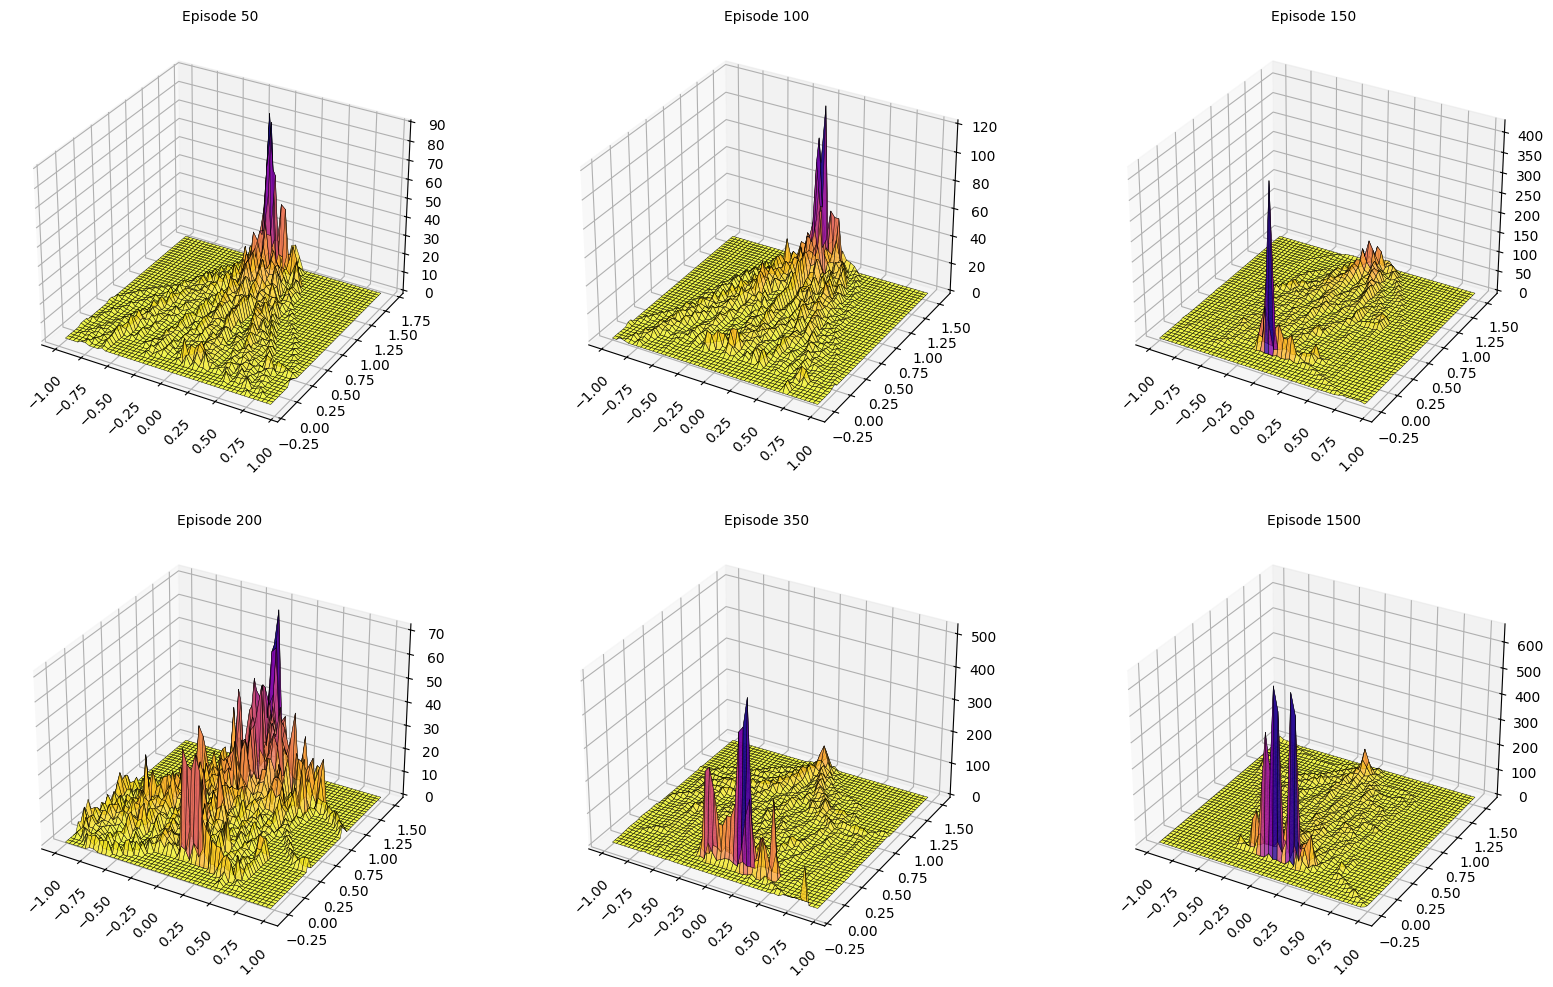

In [8]:
episodes = [50, 100, 150, 200, 350, 1500]
fig = plt.figure(figsize=(20, 12))
path = 'SARSA/'

for i, episode in enumerate(episodes):
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    plot_histograms(episode, path, ax)
plt.tight_layout(rect=[0, 0.5, 1, 0.95])  
plt.show()